In [212]:
import pandas as pd
import re
import numpy as np
import string

pd.set_option('display.max_columns', 100)  # display max rows and columns
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x)  # avoid outputing scientific notation
pd.set_option('max_colwidth', 100)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
plt.style.use('seaborn')

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

### Step 1: Sentence Segmentation
### Step 2: Word Tokenization
### Step 3: Predicting Parts of Speech for Each Token
We can do this by feeding each word (and some extra words around it for context) into a pre-trained part-of-speech classification model
### Step 4: Text Lemmatization
### Step 5: Identifying Stop Words

## Read-in The Tweets

In [188]:
# read in the tweets
tweets = pd.read_csv('judge-1377884607_tweet_product_company.csv', encoding= 'unicode_escape')

In [190]:
print('Rows:',tweets.shape[0], 'Columns:', tweets.shape[1])
tweets.head()

Rows: 9093 Columns: 3


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upg...",iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its de...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conference...",Google,Positive emotion


In [191]:
# rename and simplfiy the column names
tweets.rename(columns={'emotion_in_tweet_is_directed_at': 'subject',  # use the rename() function
                       'is_there_an_emotion_directed_at_a_brand_or_product': 'emotion',
                      'tweet_text': 'text'}, inplace=True)

tweets.columns  # check the new column names

Index(['text', 'subject', 'emotion'], dtype='object')

In [192]:
# remove any rows with no text 
tweets = tweets[tweets['text'].notnull()].copy()
tweets.shape

(9092, 3)

In [193]:
tweets['emotion'].unique()  # check what are the distinct classes

array(['Negative emotion', 'Positive emotion',
       'No emotion toward brand or product', "I can't tell"], dtype=object)

In [194]:
# rename and simplify the classes
tweets['emotion'] = tweets.emotion.map(lambda x: 'postive' if x == 'Positive emotion' else
                                      ('negative' if x == 'Negative emotion' else
                                      (x if x == "I can't tell" else 'neutral')))

## Cleaning The Tweets

In [196]:
pattern = r'(@[\w\d]+\s?)'  # to remove any mentions from the tweets 
pattern_2 = r'(https?[\S]+|www\.[\S]+)'  # to remove any links/url

tweets['no_at_links'] = tweets['text'].str.replace(pattern, '').str.replace(pattern_2,'').str.lower()

In [197]:
tweets.head()

,text,subject,emotion,no_at_links
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upg...",iPhone,negative,".i have a 3g iphone. after 3 hrs tweeting at #rise_austin, it was dead! i need to upgrade. plug..."
1,@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its de...,iPad or iPhone App,postive,"know about ? awesome ipad/iphone app that you'll likely appreciate for its design. also, they're..."
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,postive,can not wait for #ipad 2 also. they should sale them down at #sxsw.
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,negative,i hope this year's festival isn't as crashy as this year's iphone app. #sxsw
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conference...",Google,postive,"great stuff on fri #sxsw: marissa mayer (google), tim o'reilly (tech books/conferences) &amp; ma..."


In [198]:
stopwords = nltk.corpus.stopwords.words('english')
lem = WordNetLemmatizer()

In [199]:
def clean_tweet(text):
    
    text = "".join([char for char in text if char not in string.punctuation])  # remove all punctuations
    tokens = re.split('\W+', text)  # split the words on all spaces/special characters and store in a list
    
    no_stop_tokens = [word for word in tokens if word not in stopwords]
    lemmed_text = [lem.lemmatize(word) for word in no_stop_tokens]
    return lemmed_text

In [200]:
tweets['cleaned'] = tweets['no_at_links'].apply(lambda x: clean_tweet(str(x)))

In [201]:
tweets[10:15]

,text,subject,emotion,no_at_links,cleaned
11,Find &amp; Start Impromptu Parties at #SXSW With @HurricaneParty http://bit.ly/gVLrIn I can't wa...,Android App,postive,find &amp; start impromptu parties at #sxsw with i can't wait til the android app comes out.,"[find, amp, start, impromptu, party, sxsw, cant, wait, til, android, app, come]"
12,"Foursquare ups the game, just in time for #SXSW http://j.mp/grN7pK) - Still prefer @Gowalla by f...",Android App,postive,"foursquare ups the game, just in time for #sxsw - still prefer by far, best looking android app...","[foursquare, ups, game, time, sxsw, still, prefer, far, best, looking, android, app, date]"
13,Gotta love this #SXSW Google Calendar featuring top parties/ show cases to check out. RT @hamsa...,Other Google product or service,postive,gotta love this #sxsw google calendar featuring top parties/ show cases to check out. rt via =&gt;,"[gotta, love, sxsw, google, calendar, featuring, top, party, show, case, check, rt, via, gt]"
14,Great #sxsw ipad app from @madebymany: http://tinyurl.com/4nqv92l,iPad or iPhone App,postive,great #sxsw ipad app from :,"[great, sxsw, ipad, app, ]"
15,"haha, awesomely rad iPad app by @madebymany http://bit.ly/hTdFim #hollergram #sxsw",iPad or iPhone App,postive,"haha, awesomely rad ipad app by #hollergram #sxsw","[haha, awesomely, rad, ipad, app, hollergram, sxsw]"


### Apply TfidfVectorizer To Smaller Sample

In [213]:
data_sample = tweets[0:20]

tfidf = TfidfVectorizer()
X_tfidf_sample = tfidf.fit_transform(data_sample['text'])
print(X_tfidf_sample.shape)
print(tfidf_vect_sample.get_feature_names())

(20, 226)
['3g', '49n4m', '4nqv92l', 'about', 'added', 'after', 'airports', 'also', 'amp', 'an', 'and', 'android', 'app', 'apple', 'appreciate', 'apps', 'are', 'around', 'as', 'asd', 'at', 'austin', 'awesome', 'awesomely', 'axzwxb', 'be', 'beautifully', 'best', 'bit', 'books', 'buy', 'by', 'calendar', 'can', 'canadian', 'cases', 'check', 'co', 'com', 'come', 'comes', 'coming', 'communication', 'conference', 'conferences', 'corner', 'counting', 'crashy', 'ctia', 'date', 'days', 'dead', 'design', 'dollar', 'done', 'down', 'downloaded', 'dst', 'edchat', 'excited', 'fail', 'fan', 'far', 'featuring', 'festival', 'find', 'flights', 'fludapp', 'for', 'forbes', 'foursquare', 'free', 'fri', 'from', 'g4gzypv', 'galaxy', 'game', 'gear', 'giving', 'good', 'google', 'googleio', 'gotta', 'gowalla', 'gram', 'great', 'grn7pk', 'gt', 'gvlrin', 'haha', 'hamsandwich', 'have', 'holler', 'hollergram', 'hop', 'hope', 'hour', 'how', 'hrs', 'ht', 'htdfim', 'http', 'hurricaneparty', 'idea', 'iear', 'ieavob', '

In [214]:
X_tfidf_df = pd.DataFrame(X_tfidf_sample.toarray())
X_tfidf_df.columns = tfidf_vect_sample.get_feature_names()
X_tfidf_df

,3g,49n4m,4nqv92l,about,added,after,airports,also,amp,an,and,android,app,apple,appreciate,apps,are,around,as,asd,at,austin,awesome,awesomely,axzwxb,be,beautifully,best,bit,books,buy,by,calendar,can,canadian,cases,check,co,com,come,comes,coming,communication,conference,conferences,corner,counting,crashy,ctia,date,...,smart,so,speechtherapy,sprint,start,starting,stations,still,stock,store,strong,stuff,sunday,sure,swonderlin,sxsw,sxtxstate,teachntech00,tech,that,the,them,thenextweb,there,they,this,til,tim,time,tinyurl,to,top,ts,tweeting,up,upgrade,ups,users,via,wait,was,weekend,wesley83,while,will,with,wordpress,wrote,year,you
0,0.25,0.00,0.00,0.00,0.00,0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.28,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.08,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.14,0.00,0.00,0.25,0.00,0.25,0.00,0.00,0.00,0.00,0.25,0.00,0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.20,0.00,0.00,0.00,0.18,0.00,0.00,0.00,0.00,0.11,0.00,0.23,0.00,0.00,0.00,0.00,0.00,0.13,0.00,0.23,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.07,0.00,0.00,0.00,0.23,0.00,0.00,0.00,0.00,0.20,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.23,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.23
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.26,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.18,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.26,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.33,0.10,0.00,0.00,0.00,0.00,0.00,0.29,0.00,0.00,0.29,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.29,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.12,0.00,0.00,0.00,0.00,0.00,0.51,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.25,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.15,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.40,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.51,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.22,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.25,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.25,0.00,0.00,0.00,0.07,0.25,0.00,0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.25,0.00,0.00,0.00
5,0.00,0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.20,0.00,0.00,0.00,0.00,0.25,0.25,0.00,0.00,0.25,0.14,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.25,0.25,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.08,0.00,0.25,0.00,0.00,0.14,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.16,0.31,0.14,0.00,0.00,0.00,0.00,0.00,0.20,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.17,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.20,0.00,0.00,0.20,0.00,...,0.00,0.00,0.00,0.00,0.00,0.20,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0

## EDA

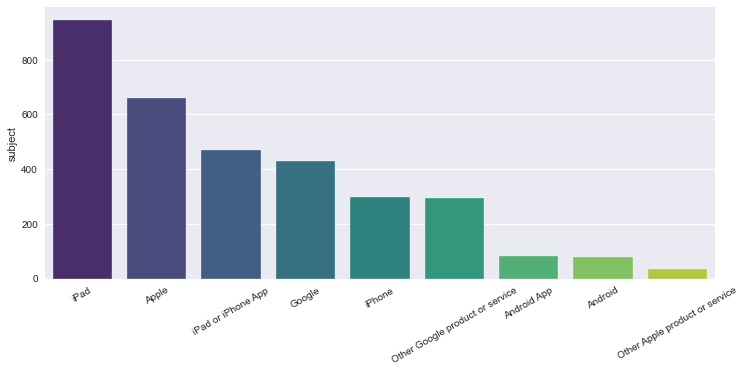

In [211]:
plt.figure(figsize=(12,5))
sns.barplot(y = tweets['subject'].value_counts(), 
            x = tweets['subject'].value_counts().index, palette='viridis', )
plt.xticks(rotation = 30)
plt.show()

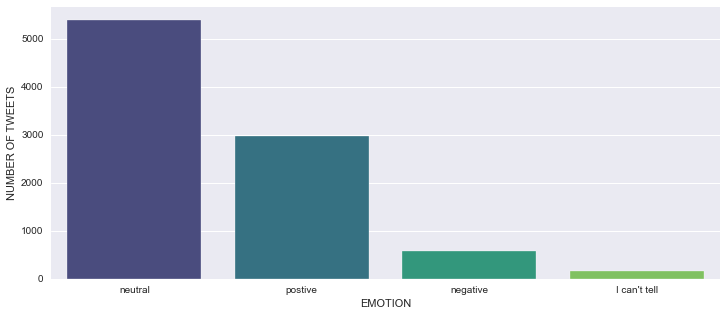

In [208]:
plt.figure(figsize=(12,5))  # see the distribution of classes

sns.barplot(y = tweets['emotion'].value_counts(dropna = False),  # use seaborn to plot bar graph
            x = tweets['emotion'].value_counts(dropna = False).index, palette='viridis' )
plt.ylabel('number of tweets'.upper())  # label the axis'
plt.xlabel('emotion'.upper())
plt.show()

In [21]:
# remove punctuations that are used for emoticons
'''
print('length before:' , len(puncs))
imp_puncs = ["'",'(', ')', ':', ';','/','|']

for punc in imp_puncs:
    puncs.remove(punc)
print('length after:', len(puncs)) 
'''

'\nprint(\'length before:\' , len(puncs))\nimp_puncs = ["\'",\'(\', \')\', \':\', \';\',\'/\',\'|\']\n\nfor punc in imp_puncs:\n    puncs.remove(punc)\nprint(\'length after:\', len(puncs)) \n'

In [22]:
## setting stopwords and punctuations
'''
sw_list = stopwords.words('english')  # should I remove some stopwords?
print(len(sw_list))

sw_list += puncs  # should I have kept all the punctuations?
sw_list += ['sxsw']  # what other common words can be removed: ipad? google?
            
sw_set = set(sw_list)
print(len(sw_set))
'''

"\nsw_list = stopwords.words('english')  # should I remove some stopwords?\nprint(len(sw_list))\n\nsw_list += puncs  # should I have kept all the punctuations?\nsw_list += ['sxsw']  # what other common words can be removed: ipad? google?\n            \nsw_set = set(sw_list)\nprint(len(sw_set))\n"